In [65]:
import json
from pathlib import Path
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

import count_heu
import adgraph
import BreakageClassifier.code.run as sinbad_features
import BreakageClassifier.code.classification.webpage_models as sinbad_models
import pandas as pd
from importlib import reload
reload(count_heu)

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
plt.rc('font', family='serif')
plt.rcParams["patch.force_edgecolor"] = True
sns.set_context("paper")
sns.set(font='serif')

sns.set_style("white", {
    'font.family': 'serif',
    'font.serif': ['Time', 'Palatino', 'serif']
})

def style_ax(ax):
    sns.despine(ax=ax, left=True)


CRAWL_POS_DIR = Path("..") / "crawl-out"/ "adguard-full"
CRAWL_NEG_DIR = Path("..") / "crawl-out"/ "adguard-neg"
SINBAD_CLASSIFIER_DIR = Path("..") / "classify-out" / "session-34" 
# SUBTREE_MODEL_FP = Path("..") / "classify-out" / "session-4" / "model=all-features=adguard.pkl"
# SUBTREE_MODEL_FP = Path("..") / "classify-out" / "session-22" / "best-nn.pkl"

OUT_DIR = Path(".") / "data"

OUT_DIR.mkdir(parents=True, exist_ok=True)

datasets = json.load(open(SINBAD_CLASSIFIER_DIR / "datasets.json"))
train_issues = pd.read_csv(SINBAD_CLASSIFIER_DIR / "train-issues.csv")
validation_issues = pd.read_csv(SINBAD_CLASSIFIER_DIR / "validation-issues.csv")
best_subtree_model = pickle.load(open(SINBAD_CLASSIFIER_DIR/'best-xgb.pkl', "rb"))

In [66]:
validation_issues.is_breaking.value_counts()

 1    143
-1     75
Name: is_breaking, dtype: int64

In [67]:
ALL_ISSUES = train_issues['issue'].unique().tolist() + validation_issues['issue'].unique().tolist()

In [ ]:
# # Preprocessing needed for the alternatives
count_heu_features = count_heu.extract_features_mult(
    crawl_dirs=[(CRAWL_POS_DIR, 1), (CRAWL_NEG_DIR, -1)],
    output_dir=OUT_DIR,
)

In [68]:
from BreakageClassifier.code.classification.dataset import Dataset, Datasets

subtree_features = Datasets(
    *[Dataset(d['name'], Path(d['path']).parent) for d in datasets]
).all.raw

In [69]:
subtree_features = subtree_features[ 
                                    # (subtree_features.n_nodes > 1)
                    # &
                    ~((subtree_features.origin == "no_fixed") & (subtree_features.edited==True))
                ]

In [ ]:
reload(adgraph)
adgraph_features = adgraph.extract_features_mult(
    crawl_dirs=[(CRAWL_POS_DIR, 1), (CRAWL_NEG_DIR, -1)],
    output_dir=OUT_DIR,
)

In [70]:
count_heu_features = pd.read_csv(OUT_DIR / "count_heu_features.csv", float_precision='round_trip')
count_heu_features['r_req_blocked'] = count_heu_features['req_blocked_new'] / count_heu_features['req_total']
adgraph_features = pd.read_csv(OUT_DIR / "adgraph_features.csv", float_precision='round_trip')

In [71]:
from typing import Optional
from sklearn.metrics import classification_report, roc_auc_score
from BreakageClassifier.code.graph.database import Database


def get_issues_from_crawls(crawl_dirs):
    
    sites_visits = []
    
    for crawl_dir in crawl_dirs:
        db_file: Path = crawl_dir / "crawl-data.sqlite"
        exp_file: Path = crawl_dir / "experiments.csv"
        
        with Database(db_file, exp_file) as database:
            sites_visits.append(database.sites_visits())
        
    sites_visits = pd.concat(sites_visits)
    return sites_visits
    

def labeled_visit_pairs(issues: pd.DataFrame, test_issue_ids: Optional[list] = None) -> list:
    
    visit_pairs = [
        ("visit_id_u", "visit_id_a", -1),
        ("visit_id_b", "visit_id_a", -1),
        ("visit_id_u", "visit_id_b", 1),
        ("visit_id_a", "visit_id_b", 1),
    ]
    
    pairs = []
    
    
    if test_issue_ids is not None:
        issues = issues[issues.issue_id.isin(test_issue_ids)]
    
    for _, row in issues.iterrows():
        for a, b, label in visit_pairs:
            pairs.append({
                "visit_id_prev": row[a],
                "visit_id_new": row[b],
                "is_broken": label,
            }
            )
     
    return pd.DataFrame(pairs)


def eval(model, issues ):
    y_pred= []
    for _, issue in issues.iterrows():
        # print("true label:", visit_pair.is_broken)
        y_pred.append(model.predict(issue.issue))
        
    print(classification_report(issues.is_breaking, y_pred))
    
    auc = roc_auc_score(issues.is_breaking, y_pred)
    
    tp, fp, tn, fn = 0, 0, 0, 0
    
    for i, pred in enumerate(y_pred):
        if pred == issues.is_breaking[i]:
            if pred == 1:
                tp += 1
            else:
                tn += 1
        else:
            if pred == 1:
                fp += 1
            else:
                fn += 1
    
    rep_dict = classification_report(issues.is_breaking, y_pred, output_dict=True)
    
    return {'Acc.': rep_dict['accuracy'], 'AUC': auc, 'Broken Precision': rep_dict['1']['precision'], 'Broken Recall': rep_dict['1']['recall'], 'Negative Precision': rep_dict['-1']['precision'], 'Negative Recall': rep_dict['-1']['recall'], 'tpr': tp/(tp+fn), 'fpr': fp/(fp+tn)}
    

In [73]:
from BreakageClassifier.code.classification.dataset import Dataset
reload(sinbad_models)

best_subtree_model = sinbad_models.ModelPipeline(
    model = best_subtree_model.model, 
    preprocessor=best_subtree_model.preprocessor,
    label_encoder = best_subtree_model.label_encoder,
    scaler = best_subtree_model.scaler,
)

class VisitPairModelWrapper:
    
    def __init__(self, model: sinbad_models.WebpageClassifier, subtree_features: Dataset):
        self.model = model
        self.subtree_features = subtree_features
        
    def predict(self, visit_prev, visit_new):
        
        subtrees= self.subtree_features[
                    (self.subtree_features['visit_id_prev'] == visit_prev) 
                    & (self.subtree_features['visit_id_new'] == visit_new)
                    # & (self.subtree_features.n_nodes > 1)
                ]
        
        if subtrees.empty:
            return -1
        
        return self.model.predict(subtrees)
    
class IssueModelWrapper:
    
    def __init__(self, model: sinbad_models.WebpageClassifier, subtree_features: Dataset):
        self.model = model
        self.subtree_features = subtree_features
        
    def predict(self, issue_id):
        
        subtrees= self.subtree_features[
                    (self.subtree_features['issue'] == issue_id)
                    # & (self.subtree_features.n_nodes > 1)
                ]
        
        if subtrees.empty:
            return -1
        
        return self.model.predict(subtrees)
        
our_classifiers = [
    ("SINBAD-K1", IssueModelWrapper(sinbad_models.ThresholdHeuristicClassifier(best_subtree_model, 1), subtree_features)),
    ("SINBAD-K3", IssueModelWrapper(sinbad_models.ThresholdHeuristicClassifier(best_subtree_model, 3), subtree_features)),
    ("SINBAD-K5", IssueModelWrapper(sinbad_models.ThresholdHeuristicClassifier(best_subtree_model, 5), subtree_features)),
    ("SINBAD-R05", IssueModelWrapper(sinbad_models.RatioHeuristicClassifier(best_subtree_model, 0.05), subtree_features)),
    ("SINBAD-R10", IssueModelWrapper(sinbad_models.RatioHeuristicClassifier(best_subtree_model, 0.1), subtree_features)),
    ("SINBAD-R15", IssueModelWrapper(sinbad_models.RatioHeuristicClassifier(best_subtree_model, 0.15), subtree_features)),
    ("SINBAD-R20", IssueModelWrapper(sinbad_models.RatioHeuristicClassifier(best_subtree_model, 0.2), subtree_features)),
    ("SINBAD-R50", IssueModelWrapper(sinbad_models.RatioHeuristicClassifier(best_subtree_model, 0.5), subtree_features)),
    # ("SINBAD-R70", IssueModelWrapper(sinbad_models.RatioHeuristicClassifier(best_subtree_model, 0.7), subtree_features)),
    # ("SINBAD-R90", IssueModelWrapper(sinbad_models.RatioHeuristicClassifier(best_subtree_model, 0.9), subtree_features)),
]

In [74]:
from sklearn.metrics import classification_report, roc_auc_score
reload(count_heu)

count_heu_classifiers = [
    ("COUNT-IMG1", count_heu.CountsThresholdHeuristic(
        ['dn_img'],
        1,
        count_heu_features,
    )), 
    ("COUNT-IMG-VIS1", count_heu.CountsThresholdHeuristic(
        ['dn_img_vis'],
        1,
        count_heu_features,
    )), 
    ("COUNT-IMG-TEXT1", count_heu.CountsThresholdHeuristic(
        ['dn_img', 'dn_#text'],
        1,
        count_heu_features,
    )), 
    ("COUNT-ALL-IMP1", count_heu.CountsThresholdHeuristic(
        ['dn_img', 'dn_#text', 'dn_button', 'dn_total_imp'],
        1,
        count_heu_features,
    )), 
    ("COUNT-REQ5", count_heu.CountsThresholdHeuristic(
        ['req_blocked_new'],
        5,
        count_heu_features,
    )), 
    ("COUNT-REQ10", count_heu.CountsThresholdHeuristic(
        ['req_blocked_new'],
        10,
        count_heu_features,
    )), 
    ("COUNT-REQ30", count_heu.CountsThresholdHeuristic(
        ['req_blocked_new'],
        30,
        count_heu_features,
    )), 
    ("RATIO-VIS10", count_heu.RatioThresholdHeuristic(
        ["r_img_vis", "r_#text_vis"],
        count_heu_features,
        threshold=0.1
    )),
    ("RATIO-VIS50", count_heu.RatioThresholdHeuristic(
        ["r_img_vis", "r_#text_vis"],
        count_heu_features,
        threshold=0.5
    )),
    ("RATIO-BASE10", count_heu.RatioThresholdHeuristic(
        ["r_img", "r_#text"],
        count_heu_features,
        threshold=0.1
    )),
    ("RATIO-BASE50", count_heu.RatioThresholdHeuristic(
        ["r_img", "r_#text"],
        count_heu_features,
        threshold=0.5
    )),
    ("RATIO-ALL10", count_heu.RatioThresholdHeuristic(
        ["r_img_vis", "r_#text_vis", "r_img", "r_#text"],
        count_heu_features,
        threshold=0.1
    )),
    ("RATIO-ALL50", count_heu.RatioThresholdHeuristic(
        ["r_img_vis", "r_#text_vis", "r_img", "r_#text"],
        count_heu_features,
        threshold=0.5
    )),
    ("RATIO-REQ10", count_heu.RatioThresholdHeuristic(
        ["r_req_blocked"],
        count_heu_features,
        threshold=0.1
    )),
    ("RATIO-REQ50", count_heu.RatioThresholdHeuristic(
        ["r_req_blocked"],
        count_heu_features,
        threshold=0.5
    )),
]

        

In [57]:
# adgraph
from xgboost import XGBClassifier
reload(adgraph)

adgraph_classifier = adgraph.AdgraphClassifier(XGBClassifier())

adgraph_classifier.fit(
    adgraph_features[~adgraph_features.issue_id.isin(validation_issues.issue.unique())]
)

adgraph_classifiers = [
    ("ADGRAPH", adgraph.IssueModelWrapper(adgraph_classifier, adgraph_features)),
]

In [58]:
reports = []


In [59]:

for model_name, model in count_heu_classifiers:
    print(model_name)
    report = eval(model, validation_issues)
    
    reports.append({
        'model': model_name,
        **report,
    })

COUNT-IMG1
              precision    recall  f1-score   support

          -1       0.30      0.67      0.41        75
           1       0.52      0.19      0.28       143

    accuracy                           0.35       218
   macro avg       0.41      0.43      0.35       218
weighted avg       0.44      0.35      0.32       218

COUNT-IMG-VIS1
              precision    recall  f1-score   support

          -1       0.30      0.67      0.41        75
           1       0.52      0.19      0.28       143

    accuracy                           0.35       218
   macro avg       0.41      0.43      0.35       218
weighted avg       0.44      0.35      0.32       218

COUNT-IMG-TEXT1
              precision    recall  f1-score   support

          -1       0.22      0.28      0.24        75
           1       0.55      0.47      0.51       143

    accuracy                           0.40       218
   macro avg       0.39      0.37      0.38       218
weighted avg       0.44      0.4

In [60]:
for model_name, model in adgraph_classifiers:
    print(model_name)
    report = eval(model, validation_issues)
    
    reports.append({
        'model': model_name,
        **report,
    })
    

ADGRAPH


              precision    recall  f1-score   support

          -1       0.63      0.39      0.48        75
           1       0.73      0.88      0.80       143

    accuracy                           0.71       218
   macro avg       0.68      0.63      0.64       218
weighted avg       0.70      0.71      0.69       218



In [61]:
for model_name, model in our_classifiers:
    print(model_name)
    report = eval(model, validation_issues)
    
    reports.append({
        'model': model_name,
        **report,
    })

SINBAD-K1
              precision    recall  f1-score   support

          -1       0.80      0.80      0.80        75
           1       0.90      0.90      0.90       143

    accuracy                           0.86       218
   macro avg       0.85      0.85      0.85       218
weighted avg       0.86      0.86      0.86       218

SINBAD-K3
              precision    recall  f1-score   support

          -1       0.53      0.92      0.67        75
           1       0.93      0.57      0.70       143

    accuracy                           0.69       218
   macro avg       0.73      0.74      0.69       218
weighted avg       0.79      0.69      0.69       218

SINBAD-K5
              precision    recall  f1-score   support

          -1       0.45      0.95      0.61        75
           1       0.93      0.38      0.54       143

    accuracy                           0.58       218
   macro avg       0.69      0.67      0.58       218
weighted avg       0.77      0.58      0.57 

In [62]:
reports = pd.DataFrame(reports)
reports

,model,Acc.,AUC,Broken Precision,Broken Recall,Negative Precision,Negative Recall,tpr,fpr
0,COUNT-IMG1,0.353211,0.427739,0.519231,0.188811,0.301205,0.666667,0.188811,0.333333
1,COUNT-IMG-VIS1,0.353211,0.427739,0.519231,0.188811,0.301205,0.666667,0.188811,0.333333
2,COUNT-IMG-TEXT1,0.403670,0.374266,0.553719,0.468531,0.216495,0.280000,0.468531,0.720000
3,COUNT-ALL-IMP1,0.403670,0.374266,0.553719,0.468531,0.216495,0.280000,0.468531,0.720000
4,COUNT-REQ5,0.555046,0.448438,0.627778,0.790210,0.210526,0.106667,0.790210,0.893333
5,COUNT-REQ10,0.463303,0.381678,0.582278,0.643357,0.150000,0.120000,0.643357,0.880000
6,COUNT-REQ30,0.389908,0.376457,0.545455,0.419580,0.231481,0.333333,0.419580,0.666667
7,RATIO-VIS10,0.385321,0.474406,0.600000,0.188811,0.329480,0.760000,0.188811,0.240000
8,RATIO-VIS50,0.380734,0.515291,0.750000,0.083916,0.351485,0.946667,0.083916,0.053333
9,RATIO-BASE10,0.380734,0.480420,0.605263,0.160839,0.333333,0.800000,0.160839,0.200000


In [63]:
print(reports.drop(columns=['tpr', 'fpr']).to_latex(
    index=False, 
    float_format="%.3f", 
    na_rep="-", 
    escape=False, 
    column_format="lcccc", 
    caption="Performance of the different classifiers on the test set of issues.")
)


\begin{table}
\centering
\caption{Performance of the different classifiers on the test set of issues.}
\begin{tabular}{lcccc}
\toprule
          model &  Acc. &   AUC &  Broken Precision &  Broken Recall &  Negative Precision &  Negative Recall \\
\midrule
     COUNT-IMG1 & 0.353 & 0.428 &             0.519 &          0.189 &               0.301 &            0.667 \\
 COUNT-IMG-VIS1 & 0.353 & 0.428 &             0.519 &          0.189 &               0.301 &            0.667 \\
COUNT-IMG-TEXT1 & 0.404 & 0.374 &             0.554 &          0.469 &               0.216 &            0.280 \\
 COUNT-ALL-IMP1 & 0.404 & 0.374 &             0.554 &          0.469 &               0.216 &            0.280 \\
     COUNT-REQ5 & 0.555 & 0.448 &             0.628 &          0.790 &               0.211 &            0.107 \\
    COUNT-REQ10 & 0.463 & 0.382 &             0.582 &          0.643 &               0.150 &            0.120 \\
    COUNT-REQ30 & 0.390 & 0.376 &             0.545 &          0.

/tmp/ipykernel_2511786/690482516.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(reports.drop(columns=['tpr', 'fpr']).to_latex(


0.8951048951048951
0.8951048951048951


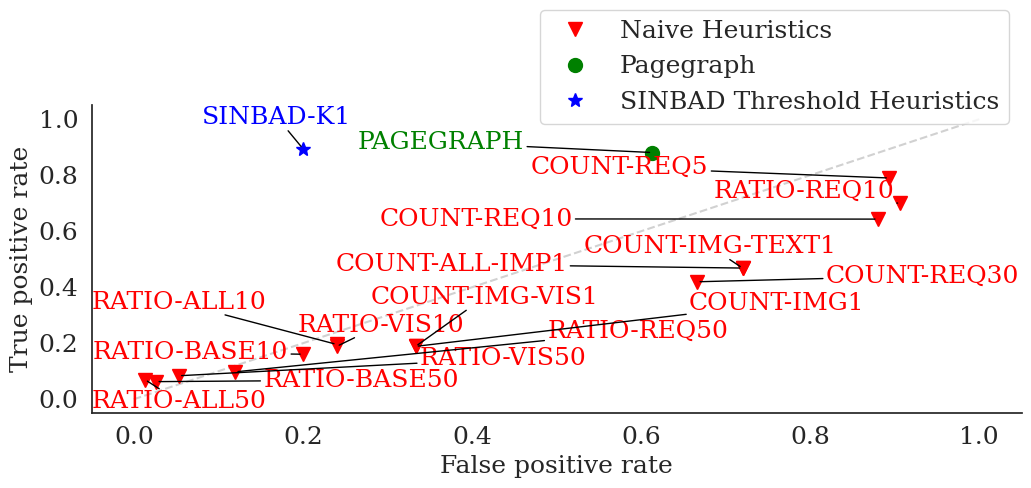

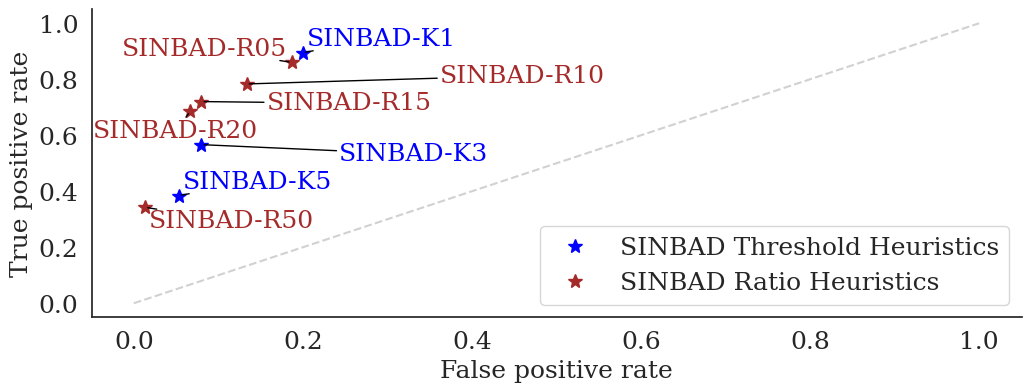

In [64]:
# plot roc points for all classifiers
import matplotlib.pyplot as plt
from adjustText import adjust_text

def scatter_plot(keywords):
    # make good for latex
    plt.rc('text', usetex=False)
    plt.rc('font', family='serif', size=18)

    plt.plot([0, 1], [0, 1], 'k--', alpha = 0.2)

    texts = []

    n_counts = 0
    n_adgraph = 0
    n_sinbad_k = 0
    n_sinbad_r = 0
    
    max_tpr  = 0

    for report in reports.itertuples():
        
        if all( not report.model.startswith(keyword) for keyword in keywords):
            continue
        
        if report.model.startswith("COUNT") or report.model.startswith("RATIO"):
            plt.plot(report.fpr, report.tpr, 'v', label="Naive Heuristics" if n_counts == 0 else None, color='red', markersize=10)
            texts.append(plt.text(report.fpr, report.tpr, report.model, color='red'))
            n_counts += 1
            
        elif report.model.startswith("ADGRAPH"):
            plt.plot(report.fpr, report.tpr, 'o', label="Pagegraph" if n_adgraph == 0 else None, color='green', markersize=10)
            texts.append(plt.text(report.fpr, report.tpr, "PAGEGRAPH", color='green'))
            n_adgraph += 1
        elif report.model.startswith("SINBAD-K"):
            plt.plot(report.fpr, report.tpr, '*', label="SINBAD Threshold Heuristics" if n_sinbad_k == 0 else None, color='blue', markersize=10)
            texts.append(plt.text(report.fpr, report.tpr, report.model, color='blue'))
            n_sinbad_k += 1
            
        elif report.model.startswith("SINBAD-R"):
            plt.plot(report.fpr, report.tpr, '*', label="SINBAD Ratio Heuristics" if n_sinbad_r == 0 else None, color='brown', markersize=10)
            texts.append(plt.text(report.fpr, report.tpr, report.model, color='brown'))
            n_sinbad_r += 1
            
        if report.tpr > max_tpr:
            max_tpr = report.tpr
            
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

    print(max_tpr)

    # despine
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # make the font bigger
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    

            
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('')
    
plt.figure(figsize=(12,4))
scatter_plot(["COUNT", "RATIO", "ADGRAPH", "SINBAD-K1"])
plt.legend(loc='upper right', fontsize=18, bbox_to_anchor=(1.0, 1.35))
plt.savefig(OUT_DIR / "model-comparison.pdf", bbox_inches='tight')

plt.figure(figsize=(12,4))
scatter_plot(["SINBAD"])
plt.legend(loc='lower right', fontsize=18)
plt.savefig(OUT_DIR / "sinbad-models.pdf", bbox_inches='tight')


# Error Analysis

## Alone

In [12]:
SINBAD_BEST = IssueModelWrapper(sinbad_models.ThresholdHeuristicClassifier(best_subtree_model, 1), subtree_features)
issue_details = pd.read_csv("../forums-out/adguard/adguard-data.csv")
rules_types = pd.read_csv("../forums-out/adguard/rule-types01.csv")
breakage_types = pd.read_csv("../forums-out/adguard/manual-breakage-type.csv")
element_types = pd.read_csv("../forums-out/adguard/manual-element.csv")

issue_details = issue_details.merge(rules_types, on= "id").merge(breakage_types, on="id").rename(columns={"breakage-type": "breakage_type"}).merge(element_types, on="id")

In [75]:
import time


y_pred= []
durations = []
for _, issue in validation_issues.iterrows():
    # print("true label:", visit_pair.is_broken)
    t_start = time.time()
    subtrees= subtree_features[
                    (subtree_features['issue'] == issue.issue)
                ]
    
    # if issue.is_breaking == 1:
        # print(SINBAD_BEST.model.subtree_model.predict(subtrees), IssueModelWrapper(sinbad_models.ThresholdHeuristicClassifier(best_subtree_model, 1), subtree_features). predict(issue.issue), IssueModelWrapper(sinbad_models.RatioHeuristicClassifier(best_subtree_model, 0.05), subtree_features).predict(issue.issue), issue.is_breaking)
    y_pred.append(SINBAD_BEST.predict(issue.issue))
    durations.append(time.time() - t_start)
    
validation_issues['pred_sinbad'] = y_pred
validation_issues[['issue', 'pred_sinbad', 'is_breaking']].to_csv(OUT_DIR / "sinbad-predictions.csv", index=False)

In [14]:
false_negatives = validation_issues[
    (validation_issues.is_breaking == 1)
    & (validation_issues.pred_sinbad == -1)
][['issue', 'pred_sinbad', 'is_breaking']].issue.unique()

true_positives = validation_issues[
    (validation_issues.is_breaking == 1)
    & (validation_issues.pred_sinbad == 1)
][['issue', 'pred_sinbad', 'is_breaking']].issue.unique()

true_negatives = validation_issues[
    (validation_issues.is_breaking == -1)
    & (validation_issues.pred_sinbad == -1)
][['issue', 'pred_sinbad', 'is_breaking']].issue.unique()

false_positives = validation_issues[
    (validation_issues.is_breaking == -1)
    & (validation_issues.pred_sinbad == 1)
][['issue', 'pred_sinbad', 'is_breaking']].issue.unique()

false_negative_details = issue_details[issue_details.id.isin(false_negatives)].copy()
true_positive_details = issue_details[issue_details.id.isin(true_positives)].copy()
true_negative_details = issue_details[issue_details.id.isin(true_negatives)].copy()
false_positive_details = issue_details[issue_details.id.isin(false_positives)].copy()

print("True positives:", len(true_positives))
print("False negatives:", len(false_negatives))
print("True negatives:", len(true_negatives))
print("False positives:", len(false_positives))



True positives: 128
False negatives: 15
True negatives: 60
False positives: 15


### Running time

In [77]:
import numpy as np


print("Mean duration:", sum(durations)/len(durations) * 1000)
print("std duration:", np.std(durations) * 1000)

Mean duration: 3.7182952285906588
std duration: 0.9460622771256937


### Breakage Type

                  True Positives  False Negatives
Static Breakage               96               10
Dynamic Breakage              32                5


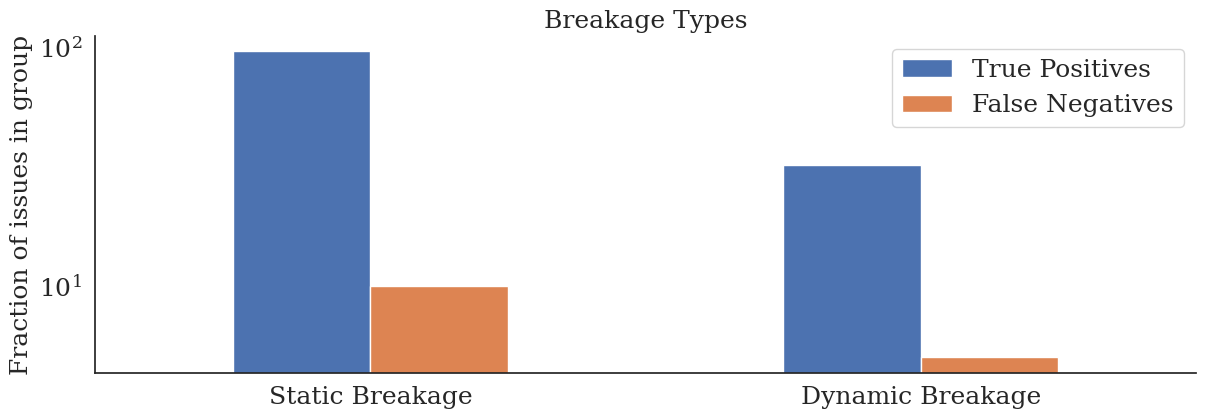

In [90]:
def plot_rule_types(*issue_details):
    
    # get the counts for each category
    
    breakage_types = []
    
    for _ , details in issue_details:
        breakage_types.append(details.breakage_type.value_counts())
    breakage_types = pd.concat(breakage_types, axis=1)
    
    breakage_types.columns = [name for name, _ in issue_details]
    
    breakage_types = breakage_types.fillna(0)
    
    breakage_types.index = breakage_types.index.str.replace("dynamic", "Dynamic Breakage")
    breakage_types.index = breakage_types.index.str.replace("static", "Static Breakage")
    print(breakage_types)
    # plot styling
    sns.set_context("paper")
    sns.set(font='serif')
    sns.set_style("white", {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif']
    })
    
    # despine
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # log y axis
    ax.set_yscale("log")
    

    # plot
    # dpi = 300
    
    
    
    breakage_types.plot.bar(figsize=(12, 4), rot=0, ax=ax)
    plt.ylabel("Fraction of issues in group")
    plt.xlabel("")
    plt.tight_layout()
    plt.title("Breakage Types", fontsize=18)
    plt.legend(loc='upper right', fontsize=18)  
    # font size
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    
    
    plt.savefig(OUT_DIR / "breakage-types-comparison.pdf", bbox_inches='tight')
    
    
plot_rule_types(
    ("True Positives", true_positive_details),
    ("False Negatives", false_negative_details),
)

### Rule Types

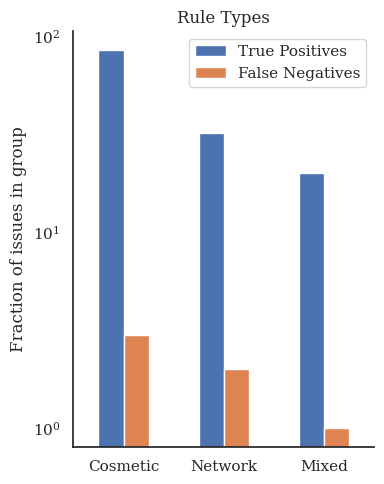

In [91]:
def plot_rule_types(*issue_details):
    
    # get the counts for each category
    
    rule_types = []
    
    for _ , details in issue_details:
        rule_types.append(details.rule.value_counts())
    rule_types = pd.concat(rule_types, axis=1)
    
    rule_types.columns = [name for name, _ in issue_details]
    
    rule_types = rule_types.fillna(0)
    
    # change the index names from CSS to Cosmetic and NET to Network and XXX to Mixed
    rule_types.index = rule_types.index.str.replace("CSS", "Cosmetic")
    rule_types.index = rule_types.index.str.replace("NET", "Network")
    rule_types.index = rule_types.index.str.replace("XXX", "Mixed")
    
    # plot styling
    sns.set_context("paper")
    sns.set(font='serif')
    sns.set_style("white", {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif']
    })
    
    # despine
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # log y axis
    ax.set_yscale("log")
    

    # plot
    rule_types.plot.bar(figsize=(4, 5), rot=0, ax=ax)
    plt.ylabel("Fraction of issues in group")
    plt.xlabel("")
    plt.title("Rule Types")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "rule-types-comparison.pdf", bbox_inches='tight')
    
    
plot_rule_types(
    ("True Positives", true_positive_details),
    ("False Negatives", false_negative_details),
)


### Element Types

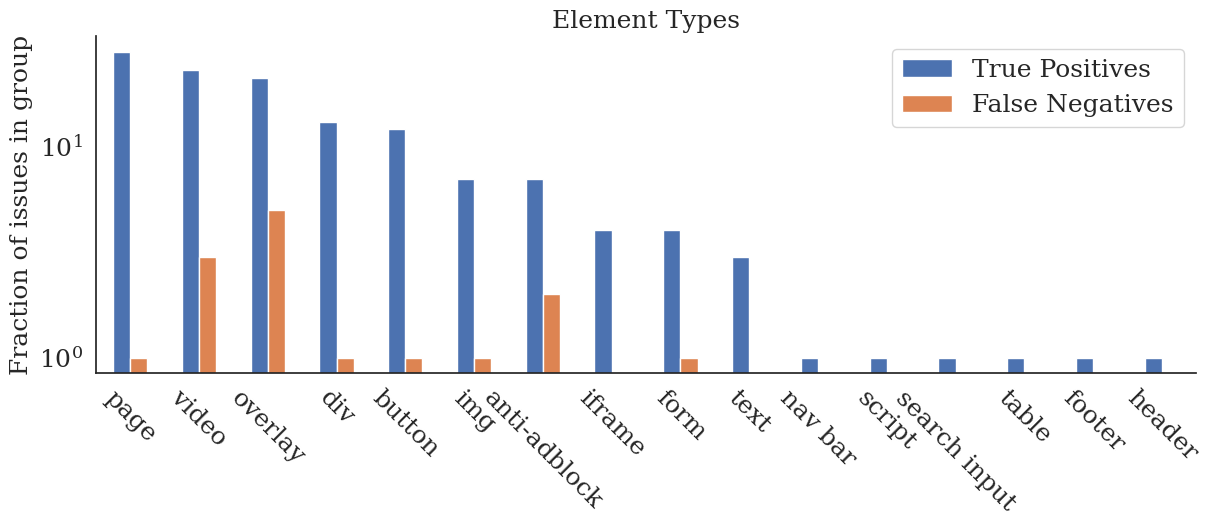

In [89]:
def plot_rule_types(*issue_details):
    
    # get the counts for each category
    
    element_types = []
    
    for _ , details in issue_details:
        element_types.append(details.element.value_counts())
    element_types = pd.concat(element_types, axis=1)
    
    element_types.columns = [name for name, _ in issue_details]
    
    element_types = element_types.fillna(0)
    
    # plot styling
    sns.set_context("paper")
    sns.set(font='serif')
    sns.set_style("white", {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif']
    })
    
    # despine
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # log y axis
    ax.set_yscale("log")


    # plot
    element_types.plot.bar(figsize=(12, 4), rot=0, ax=ax)
    plt.ylabel("Fraction of issues in group")
    plt.xlabel("")
    plt.tight_layout()
    plt.title("Element Types", fontsize=18)
    # rotate x labels
    ax.tick_params(axis='x', rotation=-45)
    
    # font size
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    
    plt.legend(loc='upper right', fontsize=18)
    
    
    plt.savefig(OUT_DIR / "element-types-comparison.pdf", bbox_inches='tight')
    
plot_rule_types(
    ("True Positives", true_positive_details),
    ("False Negatives", false_negative_details),
)

### Subtree counts

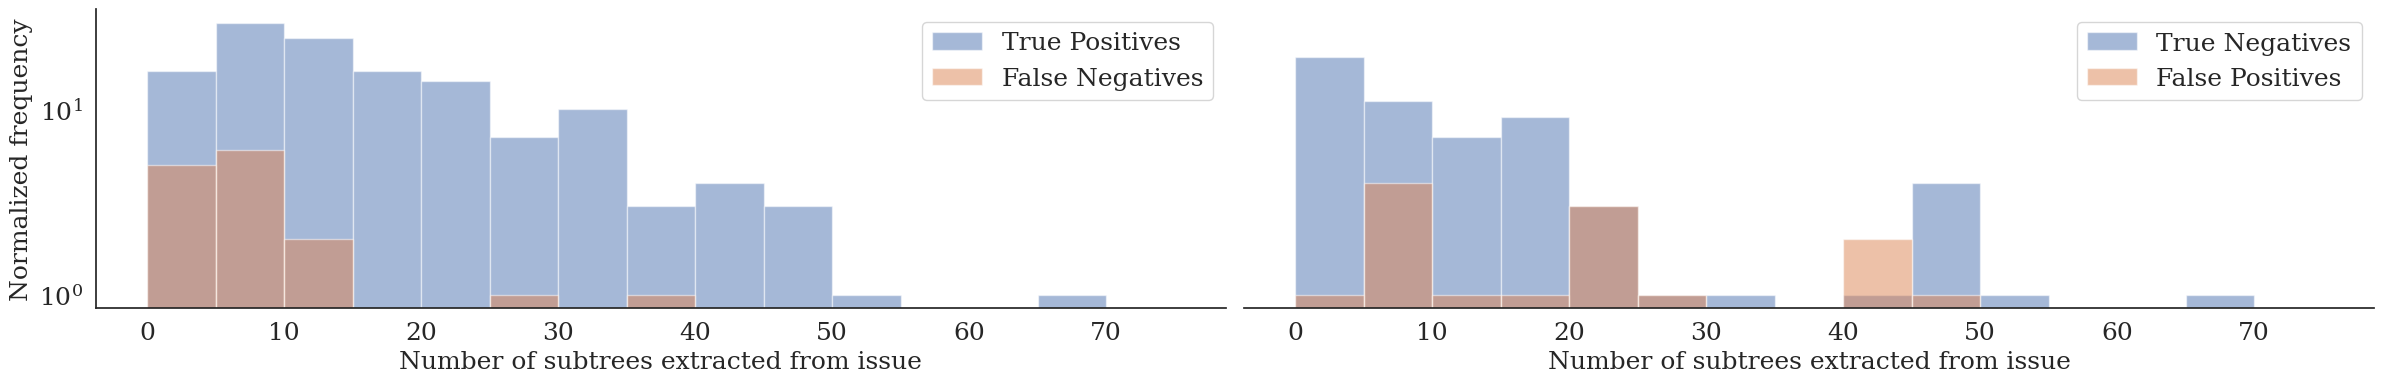

In [101]:
def get_subtree_counts(issues):
    subtrees = subtree_features[subtree_features.issue.isin(issues)]
    return subtrees.groupby("issue").size().sort_values(ascending=False)

def plot_subtree_counts(*issue_groups, ax):

    for name, issues in issue_groups:
        get_subtree_counts(issues).plot.hist(ax=ax, alpha=0.5, label=name, bins=range(0, 80, 5))
        
    ax.legend(loc='upper right', fontsize=18)
    ax.set_xlabel("Number of subtrees extracted from issue")
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #log y axis
    ax.set_yscale('log')
    
    plt.tight_layout()
    
    # font size
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    
fig, axes = plt.subplots(1, 2, figsize=(24, 4), sharey=True)

    
plot_subtree_counts(
    ("True Positives", true_positives),
    ("False Negatives", false_negatives),
    ax=axes[0]
)


plot_subtree_counts(
    ("True Negatives", true_negatives),
    ("False Positives", false_positives),
    ax=axes[1]
)


axes[0].set_ylabel("Normalized frequency")
axes[1].spines['left'].set_visible(False)

plt.savefig(OUT_DIR / "subtree-counts-comparison.pdf", bbox_inches='tight')

### Subtree predictions

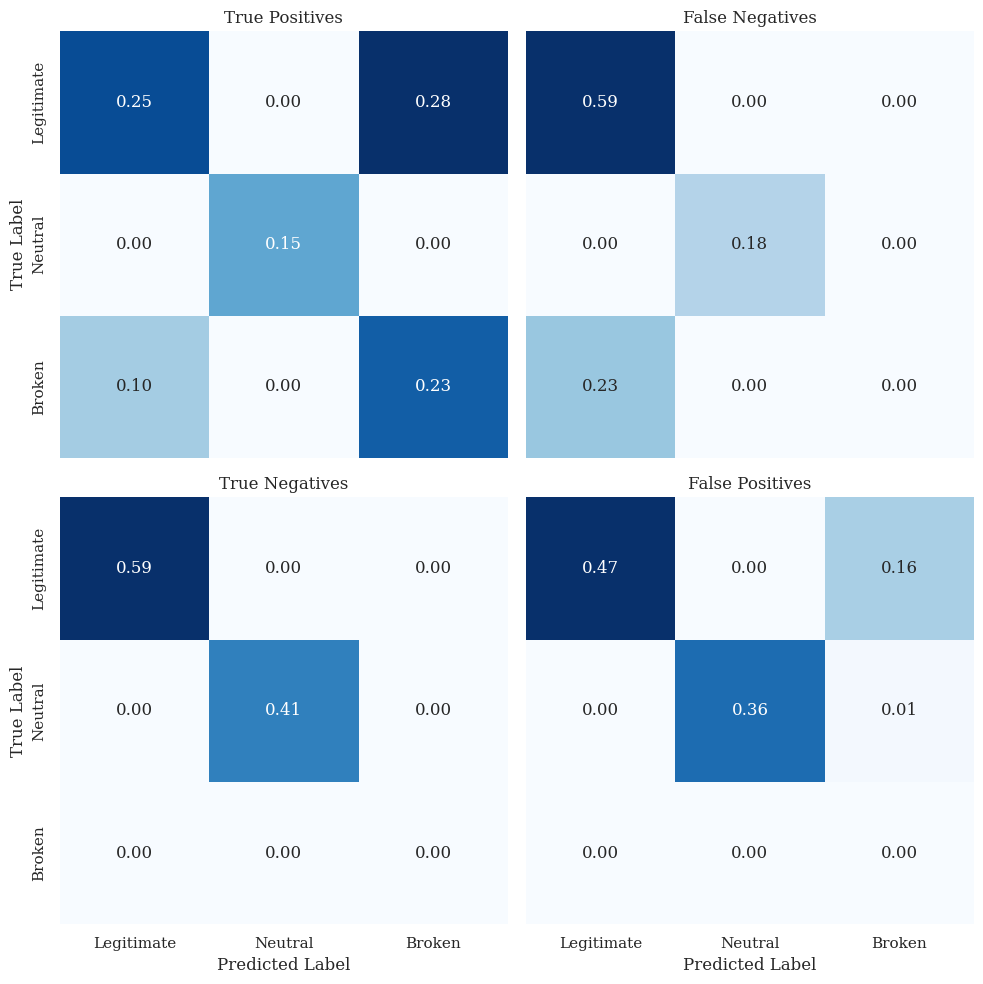

In [94]:
def subtree_prediction_table(issues):
    subtrees = subtree_features[subtree_features.issue.isin(issues)].copy()
    subtrees['pred_sinbad'] = SINBAD_BEST.model.subtree_model.predict(subtrees)
    
    # avg_table
    tables = []
    
    for issue in issues:

        table = []
        
        for label in [-1, 0, 1]:
            row = {} 
            for prediction in [-1, 0, 1]:
                
                pred_val_counts = subtrees[(subtrees.issue == issue) & (subtrees.is_breaking == label) & (subtrees.pred_sinbad == prediction)].shape[0]
                row[prediction] = pred_val_counts
    
            table.append(row)
        
        table = pd.DataFrame(table)
        table.index = ["Legitimate", "Neutral", "Broken"]
        table.columns = ["Legitimate", "Neutral", "Broken"]
        table = table.fillna(0)
        table = table.astype(int)
            
        table = table / table.sum().sum()
        tables.append(table)
        
    # average table
    avg_table = sum(tables) / len(tables)
    avg_table = avg_table.round(2)
    
    return avg_table, tables
    
def plot_table_as_heatmap(table, ax, title):
    
    # color scheme
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    
    sns.heatmap(table, annot=True, fmt=".2f", ax=ax, cmap="Blues", cbar=False)
    ax.set_title(title)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig, axes = plt.subplots(2,2 , figsize=(10, 10), sharex=True, sharey=True)

avg_table, tables = subtree_prediction_table(true_positives)
plot_table_as_heatmap(avg_table, axes[0,0], "True Positives")
axes[0,0].set_ylabel("True Label")

avg_table, tables = subtree_prediction_table(false_negatives)
plot_table_as_heatmap(avg_table, axes[0,1], "False Negatives")

avg_table, tables = subtree_prediction_table(true_negatives)
plot_table_as_heatmap(avg_table, axes[1,0], "True Negatives")
axes[1,0].set_ylabel("True Label")
axes[1,0].set_xlabel("Predicted Label")

avg_table, tables = subtree_prediction_table(false_positives)
plot_table_as_heatmap(avg_table, axes[1,1], "False Positives")
axes[1,1].set_xlabel("Predicted Label")

plt.tight_layout()


### Number of wrong predictions per issue

False Negatives
Mean: 10.133333333333333
Median: 6.0
Std: 10.048927921970204
False Positives
Mean: 33.53333333333333
Median: 20.0
Std: 51.5819274367994


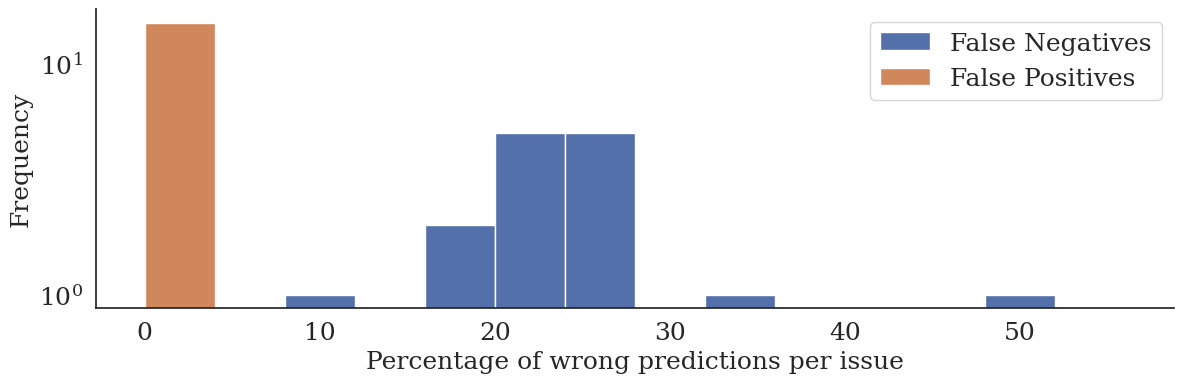

In [94]:
def plot_n_wrong_predictions_per_issue(issues, ax, name="", color="blue", bins=range(0, 60, 4)):
    subtrees = subtree_features[subtree_features.issue.isin(issues)].copy()
    subtrees['pred_sinbad'] = SINBAD_BEST.model.subtree_model.predict(subtrees)
    
    subtrees['wrong'] = (subtrees.is_breaking != subtrees.pred_sinbad) & (subtrees.is_breaking == 1)
    
    # subtrees.groupby("issue").wrong.sum().plot.hist(ax=ax, alpha=0.5, label=name, bins=bins, color=color, density=True)
    subtrees.groupby("issue").wrong.mean().apply(lambda x: 100*x).plot.hist(ax=ax, alpha=1, label=name, bins=bins, color=color)
    ax.legend()
    ax.set_xlabel("Percentage of wrong predictions per issue")
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # skip empty range in the x axis between 60 and 200 then keep values after 200
    # x_ticks = ax.get_xticks()
    
    # x_ticks = [x for x in x_ticks if (x < 60)] + [1] + [x for x in x_ticks if (x > 200)]
    
    # ax.set_xticklabels([int(x) for x in x_ticks]) 
    
    ax.set_yscale('log')
    
    plt.tight_layout()
    
    print(name)
    print("Mean:", subtrees.groupby("issue").wrong.count().mean())
    print("Median:", subtrees.groupby("issue").wrong.count().median())
    print("Std:", subtrees.groupby("issue").wrong.count().std())
    
fig, axes = plt.subplots( figsize=(12, 4))

# font size
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)



# plot_n_wrong_predictions_per_issue(
#     set(issue_details[issue_details.breakage_type == "static"].id),
#     ax=axes[0],
#     name="Static",
#     color="green",
# )

# plot_n_wrong_predictions_per_issue(
#     set(issue_details[issue_details.breakage_type == "dynamic"].id),
#     ax=axes[0],
#     name="Dynamic",
#     color="red",
# )

plot_n_wrong_predictions_per_issue(
    false_negatives,
    ax=axes,
    name="False Negatives",
    color=(0.33,0.44, 0.67)
)

plot_n_wrong_predictions_per_issue(
    false_positives,
    ax=axes,
    name="False Positives",
    color=(0.82,0.53,0.36),
)

plt.tight_layout()
plt.legend(loc='upper right', fontsize=18)
plt.savefig(OUT_DIR / "wrong-predictions-per-issue.pdf", bbox_inches='tight')

In [103]:
ISSUES_TO_IGNORE = {
    163065,
    52583,
    166652,
    154643,
    52039,
    152339,
    144838,
    164523,
    160735,
    144884,
    141090,
    143409,
    164708,
    166486,
    153647,
    153277,
    166127,
    151887,
    52869,
    53468,
    164862,
    151688,
}

### Subtree features

/tmp/ipykernel_2511786/498454531.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(x) if x < 1000 else str(int(x/1000)) + "k" for x in x_ticks])


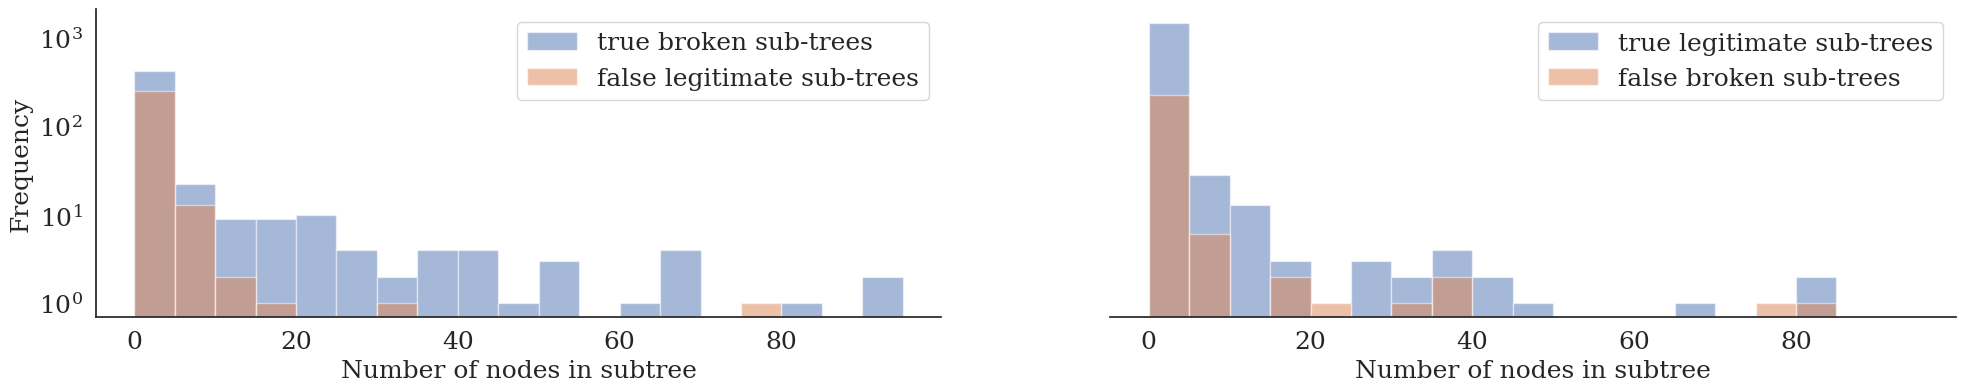

In [109]:
import numpy as np


def feature_distribution(issues, feature, axes, _range):
    subtrees = subtree_features[subtree_features.issue.isin(issues)].copy()
    subtrees['pred_sinbad'] = SINBAD_BEST.model.subtree_model.predict(subtrees)
    
    ax = axes[0]
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
        
    #log y axis
    ax.set_yscale('log')
    
    subtrees[(subtrees.is_breaking == 1) & (subtrees.pred_sinbad == 1)][feature].plot.hist(ax=ax, 
                                                                bins=_range,  
                                                                alpha=0.5, label="true broken sub-trees")
    
    subtrees[(subtrees.is_breaking == 1) & (subtrees.pred_sinbad != 1)][feature].plot.hist(ax=ax, 
                                                                bins=_range,  
                                                                alpha=0.5, label="false legitimate sub-trees")

    ax.set_xlabel("Number of nodes in subtree")
    ax.legend( fontsize=18)
    
    
    # make the ticks 1000 -> 1k
    x_ticks = ax.get_xticks()
    x_ticks = [x for x in x_ticks if (x < 1000)] + [1] + [x for x in x_ticks if (x > 1000)] 
    ax.set_xticklabels([int(x) if x < 1000 else str(int(x/1000)) + "k" for x in x_ticks])
    
    # font size
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    
    
    
    ax = axes[1]
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    subtrees[(subtrees.is_breaking == -1) & (subtrees.pred_sinbad == -1)][feature].plot.hist(ax=ax,
                                                                bins=_range,
                                                                alpha=0.5, label="true legitimate sub-trees")
    
    subtrees[(subtrees.is_breaking == -1) & (subtrees.pred_sinbad != -1)][feature].plot.hist(ax=ax,
                                                                bins=_range,
                                                                alpha=0.5, label="false broken sub-trees")
    
    ax.set_xlabel("Number of nodes in subtree")
    ax.legend( fontsize=18)
    
    ax.set_yscale('log')

    # font size
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)

def plot_feature(feature, _range, x_label = "Subtree Size on screen (in pixels squared)"):
    fig, axes = plt.subplots(1,2, figsize=(24, 4) , sharey=True)
    
    issues = set(validation_issues.issue.unique()) - ISSUES_TO_IGNORE
    feature_distribution(issues, feature, axes, _range=_range)
    # axes.set("All Issues", loc = 'left')
    # axes.set_ylabel("Frequency")
    # axes.set_xlabel(x_label)
    # axes.legend(["Legitimate", "Broken", "Neutral"], loc='upper right')
    

    # feature_distribution(true_positives, feature, axes[0,0] , _range=_range)
    # axes[0,0].set_title("True Positives", loc = 'left')
    # axes[0,0].set_ylabel("Frequency")

    # feature_distribution(false_negatives, feature, axes[0,1], _range=_range)
    # axes[0,1].set_title("False Negatives", loc = 'left')
    # axes[0,1].spines['left'].set_visible(False)
    # axes[0,1].legend(["Legitimate", "Broken", "Neutral"], loc='upper right')


    # feature_distribution(true_negatives, feature, axes[1,0], _range=_range)
    # axes[1,0].set_title("True Negatives", loc = 'left')
    # axes[1,0].set_ylabel("Frequency of subtrees")
    # axes[1,0].set_xlabel(x_label)

    # feature_distribution(false_positives, feature, axes[1,1], _range=_range)
    # axes[1,1].set_title("False Positives", loc = 'left')
    # axes[1,1].set_xlabel(x_label)
    # axes[1,1].spines['left'].set_visible(False)

    # plt.tight_layout()
    # plt.show()
    
    plt.savefig(OUT_DIR / f"{feature}-distribution.pdf", bbox_inches='tight')
    

plot_feature("n_nodes", _range=range(0, 100, 5), x_label="Subtree Size on screen (in pixels squared)")
# plot_feature("size", _range=range(0, 400000, 10000), x_label="Subtree Size on screen (in pixels squared)")
# plot_feature("n_salient", _range=range(0, 40, 1), x_label="Number of salient nodes in subtree")
# plot_feature("n_salient_covered", _range=np.arange(0, 150, 5), x_label="Number of requests added by subtree")
# plot_feature("dn_salient_covered", _range=np.arange(-40, 20, 1), x_label="Number of requests added by subtree")
# plot_feature("n_req_rem", _range=np.arange(0, 400, 10), x_label="Number of requests added by subtree")

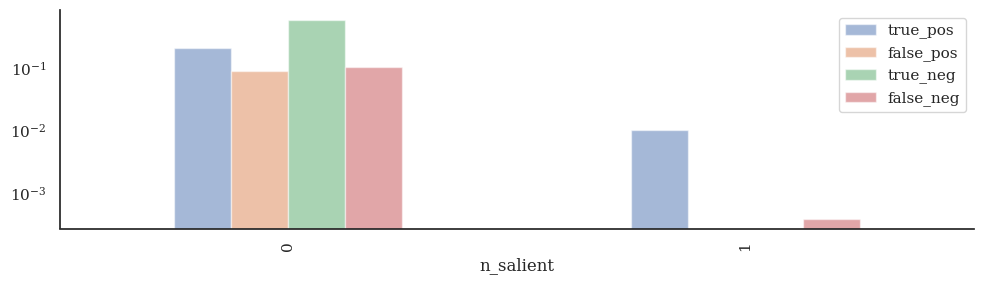

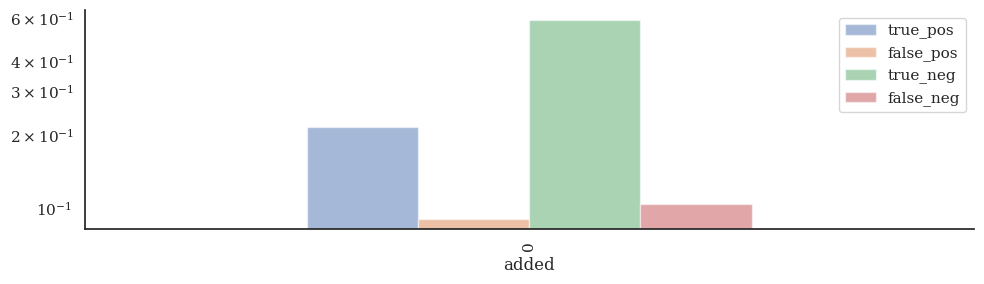

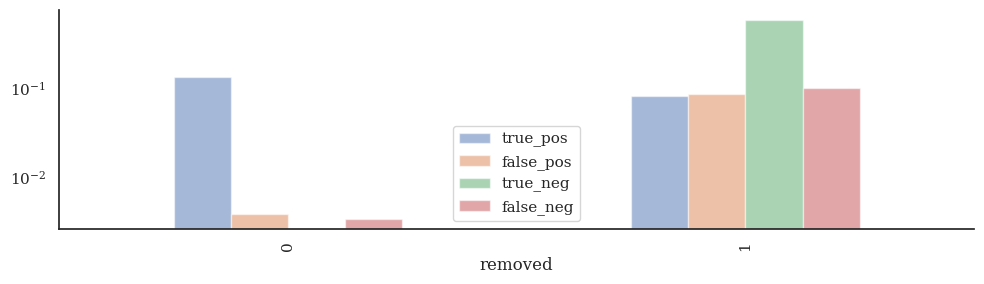

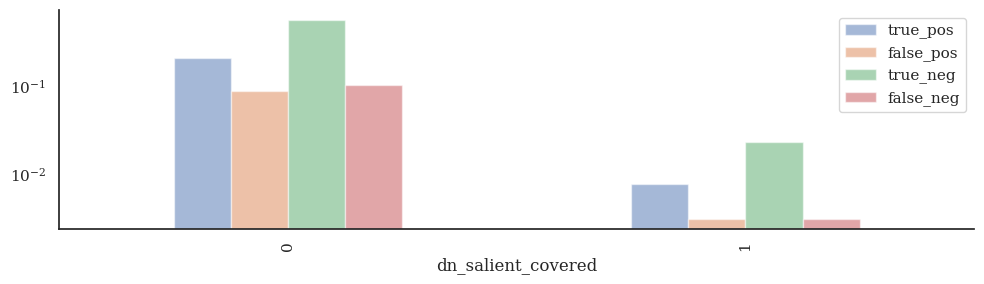

In [122]:
def threshold_feature(series, threshold= 0):
    return series.apply(lambda x: 1 if x > threshold else 0)

def feature_distribution(issues, feature, ax, _range):
    subtrees = subtree_features[subtree_features.issue.isin(issues)].copy()
    subtrees['pred_sinbad'] = SINBAD_BEST.model.subtree_model.predict(subtrees)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
        
    #log y axis
    ax.set_yscale('log')
    
    thresh_true_pos = threshold_feature(subtrees[(subtrees.is_breaking == 1) & (subtrees.pred_sinbad == 1)][feature]).value_counts().sort_index()
    thresh_false_pos = threshold_feature(subtrees[(subtrees.is_breaking == -1) & (subtrees.pred_sinbad == 1)][feature]).value_counts().sort_index()
    thresh_true_neg = threshold_feature(subtrees[(subtrees.is_breaking == -1) & (subtrees.pred_sinbad == -1)][feature]).value_counts().sort_index()
    thresh_false_neg = threshold_feature(subtrees[(subtrees.is_breaking == 1) & (subtrees.pred_sinbad == -1)][feature]).value_counts().sort_index()
    
    # plot them all on the same bar next to each other
    all_counts = pd.concat([thresh_true_pos, thresh_false_pos, thresh_true_neg, thresh_false_neg], axis=1)
    
    all_counts.columns = ["true_pos", "false_pos", "true_neg", "false_neg"]
    
    all_counts = all_counts.fillna(0)
    
    all_counts = all_counts.astype(int)
    
    all_counts = all_counts / all_counts.sum().sum()
    
    all_counts.plot.bar(ax=ax, alpha=0.5, label="true broken sub-trees")
    
    ax.set_xlabel(feature)
    # ax.set_xticklabels(["No salient nodes", "1 or more salient nodes"], rotation=0)
    
def plot_feature(feature, _range, x_label = "Subtree Size on screen (in pixels squared)"):
    fig, axes = plt.subplots( figsize=(10, 3) , sharey=True)
    issues = set(validation_issues.issue.unique()) - ISSUES_TO_IGNORE
    feature_distribution(issues, feature, axes, _range=_range)
    
    plt.tight_layout()
    
plot_feature("n_salient", _range=range(0, 40, 1), x_label="Number of salient nodes in subtree")
plot_feature("added", _range=range(0, 40, 1), x_label="Number of salient nodes in subtree")
plot_feature("removed", _range=range(0, 40, 1), x_label="Number of salient nodes in subtree")
# plot_feature("added", _range=range(0, 40, 1), x_label="Number of salient nodes in subtree")
# plot_feature("removed", _range=range(0, 40, 1), x_label="Number of salient nodes in subtree")
plot_feature("dn_salient_covered", _range=range(0, 40, 1), x_label="Number of salient nodes in subtree")

In [47]:
def subtree_predictions(issue_id):
    
    subtrees= subtree_features[
                (subtree_features['issue'] == issue_id)
                # & (subtree_features.n_nodes > 1)
            ].copy()
    
    if subtrees.empty:
        return -1
    
    subtrees['pred'] = SINBAD_BEST.model.subtree_model.predict(subtrees)
    subtrees['true'] = subtrees.is_breaking
    
    subtrees.to_csv(OUT_DIR / f"subtree-predictions-sample.csv", index=False)
    
    
    print("correct predictions:", len(subtrees[subtrees.pred == subtrees.true]))
    print("wrong predictions:", len(subtrees[subtrees.pred != subtrees.true]))
    print("total:", len(subtrees))
    print("correct 1:", len(subtrees[(subtrees.pred == subtrees.true) & (subtrees.pred == 1)]))
    print("correct -1:", len(subtrees[(subtrees.pred == subtrees.true) & (subtrees.pred == -1)]))
    print("wrong 1:", len(subtrees[(subtrees.pred != subtrees.true) & (subtrees.pred == 1)]))
    print("wrong -1:", len(subtrees[(subtrees.pred != subtrees.true) & (subtrees.pred == -1)]))
    print("total 1:", len(subtrees[subtrees.pred == 1]))
    print("total -1:", len(subtrees[subtrees.pred == -1]))
    
    print(SINBAD_BEST.predict(issue_id))

subtree_predictions(157392)


correct predictions: 11
wrong predictions: 0
total: 11
correct 1: 3
correct -1: 3
wrong 1: 0
wrong -1: 0
total 1: 3
total -1: 3
1


## Against Heuristics